# Combinando Modelos e dados: COVID-19

Ao se modelar uma epidemia real, a concordância do modelo e os dados observados é de extrema importância.

Neste Notebook vamos estudar o Modelo SEIAHR proposto para a COVID-19 por [Coelho et al](https://www.medrxiv.org/content/10.1101/2020.06.15.20132050v1). Neste modelo, temos os seguintes compartimentos:
![diagrama](seiahr.jpg)

Matemáticamente:
$$\begin{align}
\frac{dS}{dt}&=-\lambda [(1-\chi) S],\\
\frac{dE}{dt}&= \lambda [(1-\chi) S]-\alpha E,\\
\frac{dI}{dt}&= (1-p)\alpha E - \delta I -\phi I,\\
\frac{dA}{dt}&= p\alpha E - \gamma A,\\
\frac{dH}{dt}&= \phi I -(\rho+\mu) H,\\
\frac{dR}{dt}&= \delta I + \rho H+\gamma A,
\end{align}
$$

In [30]:
import numpy as np
import pandas as pd
%display typeset

In [16]:
def model(t, y, params):
    S, E, I, A, H, R, C, D = y
    chi, phi, beta, rho, delta, gamma, alpha, mu, p, q, r = params
    lamb = beta * (I + A)
    # Turns on Quarantine on day q and off on day q+r
    chi *= ((1 + np.tanh(t - q)) / 2) * ((1 - np.tanh(t - (q + r))) / 2)
    return [
        -lamb * ((1 - chi) * S),  # dS/dt
        lamb * ((1 - chi) * S) - alpha * E,  # dE/dt
        (1 - p) * alpha * E - delta * I - phi * I,  # dI/dt
        p * alpha * E - gamma * A,
        phi * I - (rho + mu) * H,  # dH/dt
        delta * I + rho * H + gamma * A,  # dR/dt
        phi * I,  # (1-p)*alpha*E+ p*alpha*E # Hospit. acumuladas
        mu * H  # Morte acumuladas
    ]           

In [17]:
chi = 0
phi = 0.012413633926076584
beta = 0.47272459855759813
rho = 0.2190519831830368
delta = 0.04168480042146949
gamma = 0.04
alpha =  0.3413355572047603
mu = 0.02359234606623134
p = 0.7693029079871165
q = 50
r = 55

In [18]:
model(0,inits, [chi,phi,beta,rho,delta,gamma,alpha,mu,p,q,r])

[-4.6799735257202214e-07,
 4.6799735257202214e-07,
 -5.40984343475461e-8,
 0.000000000000000,
 1.24136339260766e-8,
 4.16848004214695e-8,
 1.24136339260766e-8,
 0.000000000000000]

In [19]:
T = ode_solver()
T.function = model
inits = [.99, 0, 1e-6, 0, 0, 0, 0, 0]
tspan = [0,500]
T.ode_solve(tspan, inits, num_points=500, params=[chi,phi,beta,rho,delta,gamma,alpha,mu,p,q,r])

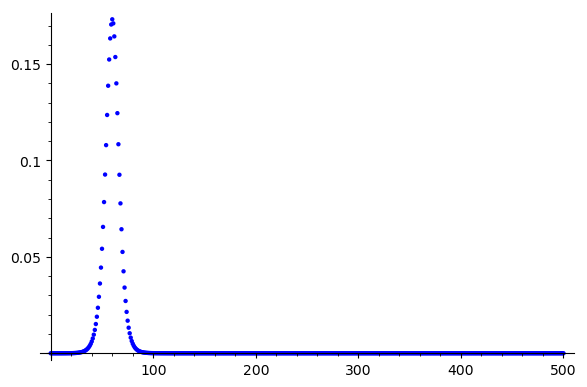

In [23]:
T.plot_solution(1)


In [24]:
def load_data(state):
    df = pd.read_csv(f'dados_{state}.csv')
    df['data'] = pd.to_datetime(df.data)
#     df.set_index('data', inplace=True)
    return df

In [32]:
dfRJ = load_data('RJ')
dfRJ

data        date  last_available_confirmed  last_available_deaths  \
0   2020-03-05  2020-03-05                         1                      0   
1   2020-03-06  2020-03-06                         2                      0   
2   2020-03-07  2020-03-07                         2                      0   
3   2020-03-08  2020-03-08                         3                      0   
4   2020-03-09  2020-03-09                         3                      0   
..         ...         ...                       ...                    ...   
100 2020-06-13  2020-06-13                     78836                   7592   
101 2020-06-14  2020-06-14                     79572                   7672   
102 2020-06-15  2020-06-15                     80946                   7728   
103 2020-06-16  2020-06-16                     83343                   7967   
104 2020-06-17  2020-06-17                     83343                   7967   

     incidencia_casos  incidencia_morte  ew  
0                 NaN               NaN  10  
1                 0.0               1.0  10  
2                 0.0               0.0  10  
3                 0.0               1.0  11  
4                 0.0               0.0  11  
..                ...               ...  ..  
100             175.0            1052.0  24  
101              80.0             736.0  25  
102              56.0            1374.0  25  
103             239.0            2397.0  25  
104               0.0               0.0  25  

[105 rows x 7 columns]

In [29]:
popRJ = 8.28e6
subnot=1

{'jupyter_client': {'name': 'jupyter_client',
  'type': 'standard',
  'installed_version': '5.2.4',
  'installed': True,
  'remote_version': '5.2.4'},
 'qepcad': {'name': 'qepcad',
  'type': 'experimental',
  'installed_version': None,
  'installed': False,
  'remote_version': 'B.1.71'},
 'database_stein_watkins': {'name': 'database_stein_watkins',
  'type': 'optional',
  'installed_version': None,
  'installed': False,
  'remote_version': '20110713'},
 'palp': {'name': 'palp',
  'type': 'standard',
  'installed_version': '2.1.p2',
  'installed': True,
  'remote_version': '2.1.p2'},
 'subprocess32': {'name': 'subprocess32',
  'type': 'standard',
  'installed_version': '3.5.3',
  'installed': True,
  'remote_version': '3.5.3'},
 'libsemigroups': {'name': 'libsemigroups',
  'type': 'optional',
  'installed_version': None,
  'installed': False,
  'remote_version': '0.6.7'},
 'valgrind': {'name': 'valgrind',
  'type': 'experimental',
  'installed_version': None,
  'installed': False,
  'remote_version': '3.14.0'},
 'givaro': {'name': 'givaro',
  'type': 'standard',
  'installed_version': '4.1.1',
  'installed': True,
  'remote_version': '4.1.1'},
 'fricas': {'name': 'fricas',
  'type': 'optional',
  'installed_version': None,
  'installed': False,
  'remote_version': '1.3.5'},
 'cryptominisat': {'name': 'cryptominisat',
  'type': 'optional',
  'installed_version': None,
  'installed': False,
  'remote_version': '5.6.8'},
 'latte_int': {'name': 'latte_int',
  'type': 'optional',
  'installed_version': None,
  'installed': False,
  'remote_version': '1.7.5.p0'},
 'libffi': {'name': 'libffi',
  'type': 'standard',
  'installed_version': '3.2.1',
  'installed': True,
  'remote_version': '3.2.1'},
 'yasm': {'name': 'yasm',
  'type': 'standard',
  'installed_version': '1.3.0.p0',
  'installed': True,
  'remote_version': '1.3.0.p0'},
 'pillow': {'name': 'pillow',
  'type': 'standard',
  'installed_version': '5.3.0.p0',
  'installed': True,
  'remote_version': '5.3.0.p0'},
 'dateutil': {'name': 'dateutil',
  'type': 'standard',
  'installed_version': '2.5.3',
  'installed': True,
  'remote_version': '2.5.3'},
 'ecl': {'name': 'ecl',
  'type': 'standard',
  'installed_version': '16.1.2.p5',
  'installed': True,
  'remote_version': '16.1.2.p5'},
 'pplpy': {'name': 'pplpy',
  'type': 'standard',
  'installed_version': '0.8.4',
  'installed': True,
  'remote_version': '0.8.4'},
 'pycosat': {'name': 'pycosat',
  'type': 'optional',
  'installed_version': None,
  'installed': False,
  'remote_version': '0.6.3'},
 'polymake': {'name': 'polymake',
  'type': 'experimental',
  'installed_version': None,
  'installed': False,
  'remote_version': '3.4'},
 'docutils': {'name': 'docutils',
  'type': 'standard',
  'installed_version': '0.14',
  'installed': True,
  'remote_version': '0.14'},
 'psutil': {'name': 'psutil',
  'type': 'standard',
  'installed_version': '5.2.0.p2',
  'installed': True,
  'remote_version': '5.2.0.p2'},
 'future': {'name': 'future',
  'type': 'standard',
  'installed_version': '0.17.1',
  'installed': True,
  'remote_version': '0.17.1'},
 'graphs': {'name': 'graphs',
  'type': 'standard',
  'installed_version': '20161026.p0',
  'installed': True,
  'remote_version': '20161026.p0'},
 'rpy2': {'name': 'rpy2',
  'type': 'standard',
  'installed_version': '2.8.2.p1',
  'installed': True,
  'remote_version': '2.8.2.p1'},
 'jmol': {'name': 'jmol',
  'type': 'standard',
  'installed_version': '14.29.52',
  'installed': True,
  'remote_version': '14.29.52'},
 'pandocfilters': {'name': 'pandocfilters',
  'type': 'standard',
  'installed_version': '1.4.2',
  'installed': True,
  'remote_version': '1.4.2'},
 'html5lib': {'name': 'html5lib',
  'type': 'standard',
  'installed_version': '1.0.1',
  'installed': True,
  'remote_version': '1.0.1'},
 'pari_seadata': {'name': 'pari_seadata',
  'type': 'optional',
  'installed_version': None,
  'installed': False,
  'remote_version': '20090618'},
 'sagenb_export': {'name': 'sagenb_export',
  'ty